In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [32]:
# Check if GPU is available
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device Name:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA Available: True
GPU Device Name: NVIDIA GeForce RTX 2070 SUPER
Using device: cuda


In [33]:
# Step 1: Generate Dummy Data
X, y = make_classification(n_samples=200, n_features=10, n_informative=8, n_redundant=2, 
                           n_classes=2, random_state=42)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [36]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [37]:
# Function to create MLP model
def create_model(input_size, hidden_layers, activation_fn):
    layers = []
    last_size = input_size
    for hidden_size in hidden_layers:
        layers.append(nn.Linear(last_size, hidden_size))
        layers.append(activation_fn())
        last_size = hidden_size
    layers.append(nn.Linear(last_size, 1))
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers).to(device)

In [38]:
# Parameters to compare
hidden_layer_configs = [[4], [8], [16], [32], [64], [128], [4, 8], [8, 16], [16, 32], [32, 64], [64, 128]]
activation_functions = [nn.ReLU, nn.Sigmoid, nn.Tanh, nn.Identity]
epochs_list = [1, 10, 25, 50, 100, 250]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128, 256, 512]

Hidden Layers: [4], Activation: ReLU, Epochs: 1, LR: 10, Batch Size: 16, Accuracy: 0.3000
Hidden Layers: [4], Activation: ReLU, Epochs: 1, LR: 10, Batch Size: 32, Accuracy: 0.4000
Hidden Layers: [4], Activation: ReLU, Epochs: 1, LR: 10, Batch Size: 64, Accuracy: 0.7000
Hidden Layers: [4], Activation: ReLU, Epochs: 1, LR: 10, Batch Size: 128, Accuracy: 0.3000
Hidden Layers: [4], Activation: ReLU, Epochs: 1, LR: 10, Batch Size: 256, Accuracy: 0.6750
Hidden Layers: [4], Activation: ReLU, Epochs: 1, LR: 10, Batch Size: 512, Accuracy: 0.3000
Hidden Layers: [4], Activation: ReLU, Epochs: 1, LR: 1, Batch Size: 16, Accuracy: 0.5500
Hidden Layers: [4], Activation: ReLU, Epochs: 1, LR: 1, Batch Size: 32, Accuracy: 0.7000
Hidden Layers: [4], Activation: ReLU, Epochs: 1, LR: 1, Batch Size: 64, Accuracy: 0.7000
Hidden Layers: [4], Activation: ReLU, Epochs: 1, LR: 1, Batch Size: 128, Accuracy: 0.4750
Hidden Layers: [4], Activation: ReLU, Epochs: 1, LR: 1, Batch Size: 256, Accuracy: 0.5750
Hidden Lay

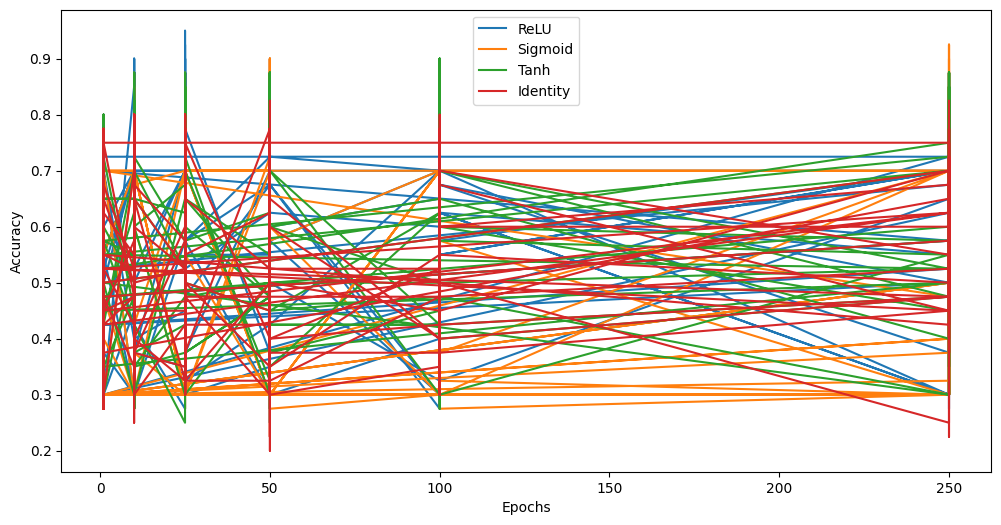

In [39]:
# Evaluate combinations
results = []
for hidden_layers in hidden_layer_configs:
    for activation_fn in activation_functions:
        for epochs in epochs_list:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                    # Create model
                    model = create_model(X_train.shape[1], hidden_layers, activation_fn)
                    criterion = nn.BCELoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    # Train model
                    model.train()
                    for epoch in range(epochs):
                        for batch_X, batch_y in train_loader:
                            optimizer.zero_grad()
                            outputs = model(batch_X)
                            loss = criterion(outputs, batch_y)
                            loss.backward()
                            optimizer.step()

                    # Evaluate model
                    model.eval()
                    correct = 0
                    total = 0
                    with torch.no_grad():
                        for batch_X, batch_y in test_loader:
                            outputs = model(batch_X)
                            predicted = (outputs >= 0.5).float()
                            total += batch_y.size(0)
                            correct += (predicted == batch_y).sum().item()

                    accuracy = correct / total
                    results.append({
                        'hidden_layers': hidden_layers,
                        'activation_fn': activation_fn.__name__,
                        'epochs': epochs,
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'accuracy': accuracy
                    })
                    print(f"Hidden Layers: {hidden_layers}, Activation: {activation_fn.__name__}, Epochs: {epochs}, LR: {lr}, Batch Size: {batch_size}, Accuracy: {accuracy:.4f}")

# Save results to CSV
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv("Classification_Dummy.csv", index=False)

# Plotting results (example for one parameter comparison)
plt.figure(figsize=(12, 6))
for activation_fn in results_df['activation_fn'].unique():
    subset = results_df[results_df['activation_fn'] == activation_fn]
    plt.plot(subset['epochs'], subset['accuracy'], label=f"{activation_fn}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()